# **Load all dependencies we need¶**

In [1]:
!pip install efficientnet_pytorch # bc we will use efficientnet_pytorch to import EfficientNet and use it in our model.

import os # provides functions for iteractions with operation system
from tqdm import tqdm # To show progress maters or progress bars
import matplotlib.pyplot as plt # To plot the images
from PIL import Image
import torch #Framework that we will use
from torch import nn # PyTorch provides the torch.nn module to help us in creating and training of the neural network
from torch import optim #package implementing various optimization algorithms.
from torch.utils.data import Dataset #to create our dataset.
from torch.utils.data import DataLoader #to create mini batch sizes.
import torchvision.transforms as T#to make all the images in the same size.
import numpy as np # linear algebra
from efficientnet_pytorch import EfficientNet # To transfer learnig

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=de74309c4ce7f16ba2d31fc0099bb14287c8bfb8946bbddd3bb4ff7b79905938
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet_pytorch


Let's seed everything to make results somewhat reproducible

In [2]:
def seed_everything(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Dataset

In [3]:
class DrowsinesDataset(Dataset):
    def __init__(self, root_dir): # root_dir is the path where we have the data
        super(DrowsinesDataset, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.class_names = os.listdir(root_dir)
        self.transform = T.Resize(97)
        
        for index, name in enumerate(self.class_names):
            files = os.listdir(os.path.join(root_dir, name))
            self.data += list(zip(files, [index]*len(files)))
#for classificate our data from 0 to close eyes and 1 to open eyes
#the output will be a liste contain "((s.....),0 or 1)" for each file in it
    def __len__(self):
        return len(self.data)
    #get the len of the data(open plus close eyes)

    def __getitem__(self, index):
        img_file, label = self.data[index]#get each image in the data
        root_and_dir = os.path.join(self.root_dir, self.class_names[label])#join the path and class names
        image = Image.open(os.path.join(root_and_dir, img_file)).convert("RGB")#joing the path and classe names with image file and read it like an white and black image
        image = np.array(self.transform(image))#translat it in np array(list)
        
        return image, label

# Hyperparameters

In [4]:
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
LEARNING_RATE = 4e-4
NUM_EPOCHS = 5

# Get and check Data loader

torch.Size([128, 97, 97, 3]) torch.Size([128])


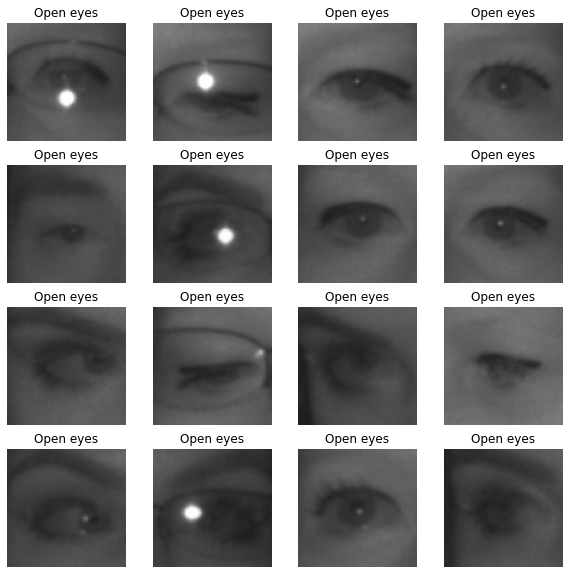

In [5]:
train_ds = DrowsinesDataset(root_dir="../input/human-eyes-openclose-tipe/train/")
test_ds  = DrowsinesDataset(root_dir="../input/human-eyes-openclose-tipe/test/")

#loader; creat mini batch size from the dataset
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,  shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)#there are no need to shuffle the data in the test period, it's don't make change

#just to check our data loader
img, lbl = next(iter(test_loader))
print(img.shape, lbl.shape)

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img[i])
    plt.axis("off")
    name = ['Open eyes', 'Close eyes'][lbl[i].item()]
    ax.set_title(name)

# model

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.eff    = EfficientNet.from_pretrained('efficientnet-b0')
        self.out    = nn.Linear(1000, 1)
        self.sigmoid= nn.Sigmoid()

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.eff(x)
        #print(x.shape)
        x = self.out(x)
        x = self.sigmoid(x)
        return x
    
# Check model
x = torch.randn((BATCH_SIZE,3,80,80))
model = Model()
model(x).shape

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


torch.Size([128, 1])

# check accuracy

In [7]:
def chek_accuracy(loader, model, device):
    nbr_correct =0
    nbr_samples =0

    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader):
            # x -:> image and y -> label
            x = x.to(device).permute(0,3,1,2)
            y = y.to(device).unsqueeze(1)#(128,1) 
            prediction = model(x) 
            prediction = (prediction>0.5).float()
            nbr_correct += (prediction == y).sum()	#(128,1) 
            nbr_samples += prediction.shape[0]
        

    print('Got: '+str(nbr_correct.item())+'/'+str(nbr_samples) + ' with acuuracy ' + str((nbr_correct/ nbr_samples).item())+'%' )
    model.train() 
    return (nbr_correct/ nbr_samples).item()

# Train function

In [8]:
def train_fn(loader, model, loss_fn, optimizer, device):#device(cuda or cpu)
    for image, label in tqdm(loader): 
        
        
        # Trasnform label from shape (128) to (128,1) 
        # label.unsqueeze(0) Trasnform label from shape (128) to (1,128)
        image             = image.to(device).permute(0,3,1,2)
        label             = label.unsqueeze(1).to(device)
        #Forward
        predecting_output = model(image)
        loss              = loss_fn(predecting_output, label.float())
        #Backward
        model.zero_grad()
        loss.backward()
        optimizer.step()

# Training and evaluation

In [9]:
loss_fn   = nn.BCELoss()
model     = Model().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
score     = 0

chek_accuracy(test_loader,model, DEVICE)

for epoch in range(NUM_EPOCHS):
    print('############ Epoch: '+str(epoch))
    train_fn(train_loader, model, loss_fn, optimizer, DEVICE)
    acc = chek_accuracy(test_loader,model, DEVICE)
    chek_accuracy(train_loader,model, DEVICE)
    if score < acc:
        score = acc
        torch.save(model.state_dict(), 'checkpoint.h5')
        print('loading model')


Loaded pretrained weights for efficientnet-b0


100%|██████████| 195/195 [01:27<00:00,  2.23it/s]


Got: 10734/24926 with acuuracy 0.43063464760780334%
############ Epoch: 0


100%|██████████| 195/195 [00:25<00:00,  7.60it/s]


Got: 24233/24926 with acuuracy 0.9721976518630981%


100%|██████████| 469/469 [01:05<00:00,  7.13it/s]


Got: 59320/59972 with acuuracy 0.9891282916069031%
loading model
############ Epoch: 1


100%|██████████| 195/195 [00:25<00:00,  7.56it/s]


Got: 24233/24926 with acuuracy 0.9721976518630981%


100%|██████████| 469/469 [01:05<00:00,  7.19it/s]


Got: 59527/59972 with acuuracy 0.9925798773765564%
############ Epoch: 2


100%|██████████| 195/195 [00:25<00:00,  7.53it/s]


Got: 24213/24926 with acuuracy 0.9713953137397766%


100%|██████████| 469/469 [01:05<00:00,  7.16it/s]


Got: 59600/59972 with acuuracy 0.9937971234321594%
############ Epoch: 3


100%|██████████| 195/195 [00:25<00:00,  7.70it/s]


Got: 23901/24926 with acuuracy 0.958878219127655%


100%|██████████| 469/469 [01:06<00:00,  7.06it/s]


Got: 59504/59972 with acuuracy 0.9921963810920715%
############ Epoch: 4


100%|██████████| 195/195 [00:26<00:00,  7.28it/s]


Got: 24433/24926 with acuuracy 0.9802213907241821%


100%|██████████| 469/469 [01:06<00:00,  7.11it/s]

Got: 59684/59972 with acuuracy 0.9951977729797363%
loading model
